# 1. BERT

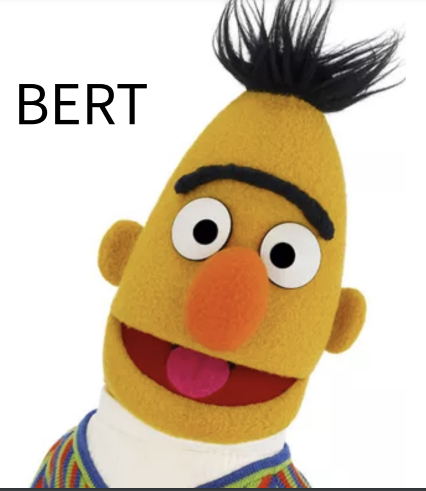

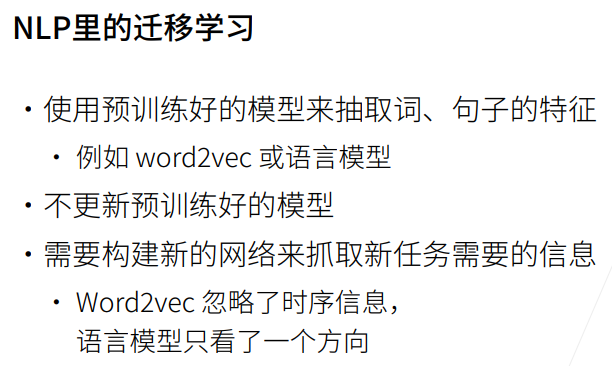

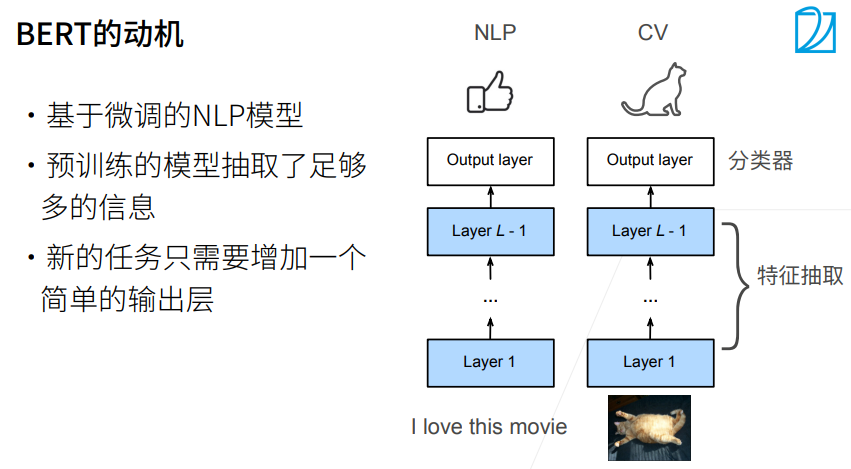

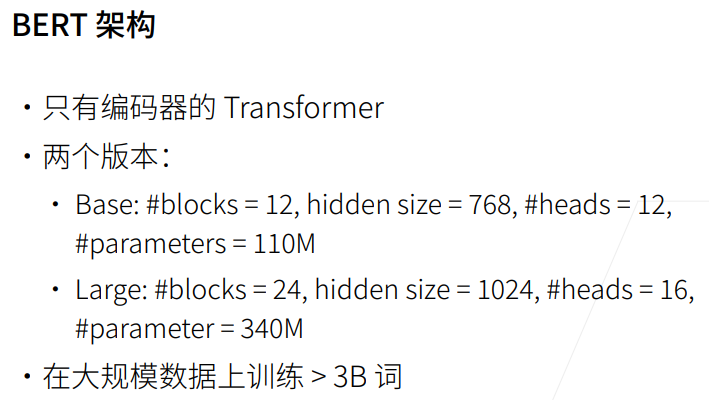

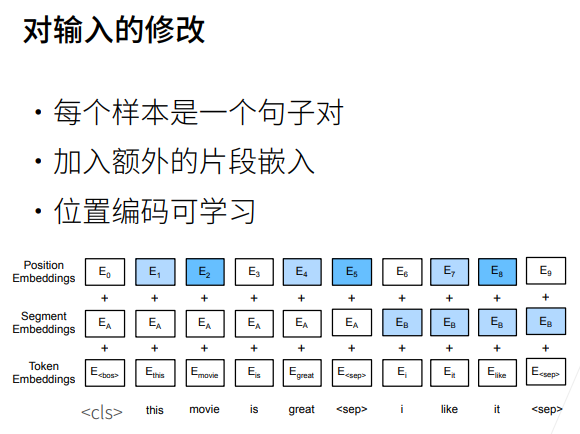

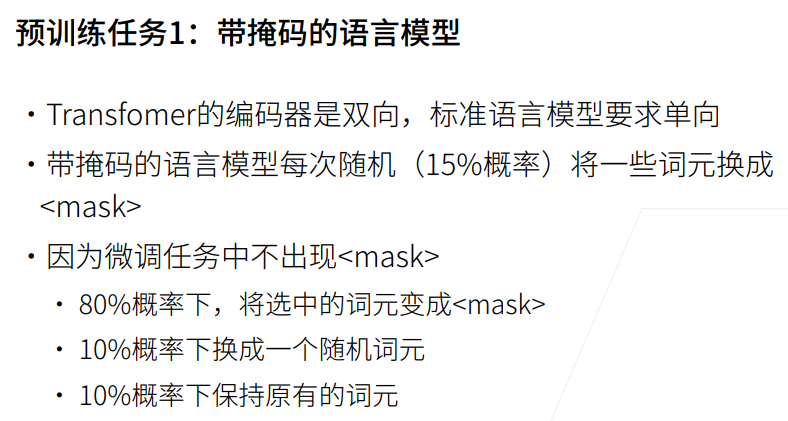

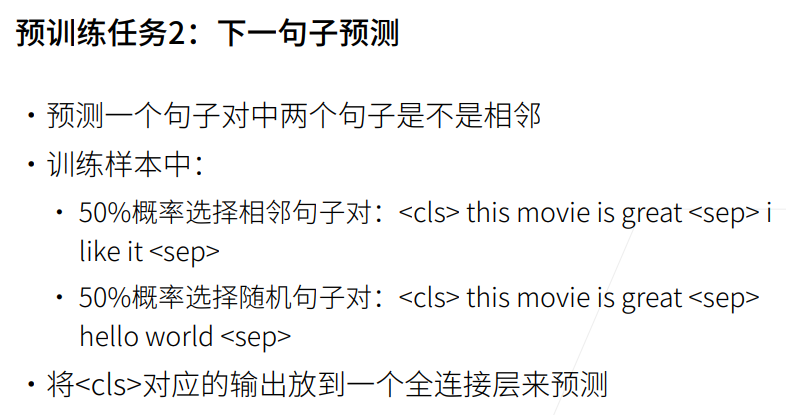

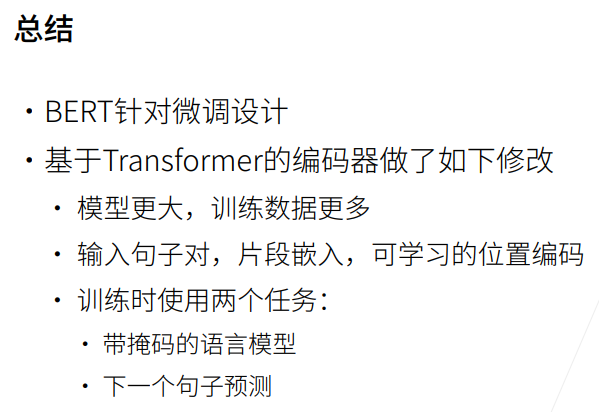

# 2. BERT

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# Input Representation
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs"""   
    # 添加特殊标记，并连接第一个句子的标记
    tokens = ['<cls>'] + tokens_a + ['<seq>']
    # 第一个句子的段ID都为0
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        # 如果存在第二个句子，则连接第二个句子的标记
        tokens += tokens_b + ['<seq>']
        # 第二个句子的段ID都为1
        segments += [1] * (len(tokens_b) + 1)
    # 返回转换后的标记列表和段ID列表
    return tokens, segments

In [3]:
# BERTEncoder class
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, num_layers, dropout,
                max_len=1000, key_size=768, query_size=768, value_size=768,
                **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        # 标记嵌入层
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        # 段嵌入层
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        # BERT编码器块的序列容器
        self.blks = nn.Sequential()
        for i in range(num_layers):
            # 添加BERT编码器块
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))   
    
    def forward(self, tokens, segments, valid_lens):
        # 计算输入序列的嵌入表示
        X = self.token_embedding(tokens) + self.segment_embedding(segments)  
        # 添加位置嵌入
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            # 通过BERT编码器块进行编码
            X = blk(X, valid_lens)
        return X

In [4]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        # 标记嵌入层
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        # 段嵌入层
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        # BERT编码器块的序列容器
        self.blks = nn.Sequential()
        for i in range(num_layers):
            # 添加BERT编码器块
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 计算嵌入表示
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        # 添加位置嵌入
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            # 进行编码
            X = blk(X, valid_lens)
        return X

In [5]:
# Inference of BERTEncoder
# 定义BERT编码器的参数
# vocab_size: 词汇表大小
# num_hiddens: 隐藏单元数
# ffn_num_hiddens: 前馈神经网络隐藏层大小
# num_heads: 注意力头数
# norm_shape: 规范化层的形状
# ffn_num_input: 前馈神经网络输入大小
# num_layers: 编码器层数
# dropout: dropout概率
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
# 创建BERT编码器实例
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                     ffn_num_hiddens, num_heads, num_layers, dropout)
# 随机生成标记
tokens = torch.randint(0, vocab_size, (2,8))
# 创建段向量
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])  
# 进行BERT编码
encoded_X = encoder(tokens, segments, None)
# 输出编码后的表示结果的形状
encoded_X.shape

torch.Size([2, 8, 768])

In [6]:
# Masked Language Modeling
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),  # 全连接层：输入维度为num_inputs，输出维度为num_hiddens
                                nn.ReLU(), # ReLU激活函数
                                nn.LayerNorm(num_hiddens),  # LayerNorm层，归一化输入
                                nn.Linear(num_hiddens, vocab_size)) # 全连接层：输入维度为num_hiddens，输出维度为vocab_size
    
    def forward(self, X, pred_positions):
        # 预测位置数量
        num_pred_positions = pred_positions.shape[1]
        # 重塑预测位置张量为一维向量
        pred_positions = pred_positions.reshape(-1)
        # 批量大小
        batch_size = X.shape[0]
        # 创建批量索引向量
        batch_idx = torch.arange(0, batch_size)
        # 重复批量索引以匹配预测位置索引
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)  
        # 从X中提取被掩盖的输入
        masked_X = X[batch_idx, pred_positions]
        # 重塑masked_X张量的形状
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        # 将masked_X传递给MLP网络，得到MLM任务的预测结果
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [7]:
# The forward inference of MaskLM
# 创建MaskLM模型实例
mlm = MaskLM(vocab_size, num_hiddens)
# 创建MLM任务的预测位置张量
mlm_positions = torch.tensor([[1,5,2],[6,1,5]])
# 输入编码后的文本和预测位置，得到MLM任务的预测结果
mlm_Y_hat = mlm(encoded_X, mlm_positions)
# 打印MLM任务的预测结果的形状
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [8]:
# 创建MLM任务的目标张量
mlm_Y = torch.tensor([[7,8,9],[6,1,5]])
# 创建交叉熵损失函数实例
loss = nn.CrossEntropyLoss(reduction='none')
# 计算MLM任务的损失
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
# 打印MLM任务的损失的形状
mlm_l.shape

torch.Size([6])

In [9]:
# Next Sentence Prediction
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        # 全连接层用于预测下一句的概率
        self.output = nn.Linear(num_inputs, 2)
    
    def forward(self, X):
        # 输出下一句的预测结果
        return self.output(X)

In [10]:
# The forward inference of an NextSentencePred
# 将encoded_X展平为二维张量
encoded_X = torch.flatten(encoded_X, start_dim=1)
# 创建NextSentencePred实例，输入大小为encoded_X的最后一维大小
nsp = NextSentencePred(encoded_X.shape[-1])
# 使用nsp对encoded_X进行前向传播，得到下一句预测的结果
nsp_Y_hat = nsp(encoded_X)
# 打印下一句预测结果的形状
nsp_Y_hat.shape

torch.Size([2, 2])

In [11]:
# 创建下一句预测的标签张量
nsp_y = torch.tensor([0,1])
# 计算下一句预测的损失
nsp_l = loss(nsp_Y_hat, nsp_y)
# 打印下一句预测损失的形状
nsp_l.shape

torch.Size([2])

In [12]:
# Putting All Things Together
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, num_layers, dropout,
                max_len=1000, key_size=768, mlm_in_features=768,
                nsp_in_features=768):
        super(BERTModel, self).__init__()
        # BERT编码器
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                                  ffn_num,input, ffn_num_hiddens, num_heads, num_layers,
                                  dropout, max_len=max_len, key_size=key_size)
        # 隐藏层
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens), nn.Tanh())   
        # 掩码语言模型
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        # 下一句预测模型
        self.nsp = NextSentencePred(nsp_in_features)
        
    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        # 使用编码器对输入进行编码
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            # 如果传入了pred_positions参数，则调用掩码语言模型进行预测
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 将encoded_X的第一个位置的隐藏表示通过隐藏层进行转换
        # 使用下一句预测模型进行预测
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

# 3. BERT预训练数据集

In [13]:
import os
import random
import torch
from d2l import torch as d2l

In [14]:
# The WikiText-2 dataset
# 将WikiText-2数据集添加到d2l的数据集中心
d2l.DATA_HUB['wikitext-2'] = ('https://s3.amazonaws.com/research.metamind.io/wikitext/'
                             'wikitext-2-v1.zip','3c914d17d80b1459be871a5039ac23e752a53cbe')   

def _read_wiki(data_dir):
    # 读取WikiText-2数据集的训练集文件
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r', encoding='utf-8') as f:
        # 逐行读取文件内容
        lines = f.readlines()
    # 将每行内容按句号分割成段落，并转换为小写
    paragraphs = [line.strip().lower().split(' . ')
                 for line in lines if len(line.split(' . ')) >= 2]
    # 随机打乱段落的顺序
    random.shuffle(paragraphs)
    return paragraphs

In [15]:
# Generating the Next Sentence Prediction Task
def _get_next_sentence(sentence, next_sentence, paragraphs):
    # 随机决定两个句子是否是下一个句子关系
    if random.random() < 0.5:
        is_next = True
    else:
        # 从随机选择的段落中选择一个句子作为下一个句子
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        # 获取当前句子和下一个句子以及它们之间的关系
        tokens_a, tokens_b, is_next = _get_next_sentence(paragraph[i], paragraph[i + 1], paragraphs)
        # 如果两个句子加上特殊标记的长度超过了最大长度，则跳过该句对
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        # 获取句子的token和segment表示
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [16]:
# Generating the Masked Language Modeling Task
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    # 生成用于MLM任务的输入tokens，同时返回预测位置和标签
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        # 如果已经预测了足够数量的位置，则结束
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 随机决定当前位置是否进行mask操作
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 随机决定是替换为当前token还是随机选择一个token作为替换
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            else:
                masked_token = random.randint(0, len(vocab) - 1)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))  
    return mlm_input_tokens, pred_positions_and_labels

def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    for i, token in enumerate(tokens):
        # 跳过特殊标记的位置
        if token in ['<cls>','<sep>']:
            continue
        candidate_pred_positions.append(i)
    num_mlm_preds = max(1, round(len(tokens) * 0.15))    
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    # 按照预测位置的顺序进行排序
    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x:x[0])   
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]     

In [17]:
# Append the special "<mask>" tokens to the inputs
def _pad_bert_inputs(examples, max_len, vocab):
    # 计算最大的预测位置数量
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens, = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    # 遍历每个样本
    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        # 将输入 token 填充到指定长度，并转换为张量
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (max_len - len(token_ids)), dtype=torch.long))     
        # 将输入 segment 填充到指定长度，并转换为张量
        all_segments.append(torch.tensor(segments + [0] * (max_len - len(segments)), dtype=torch.long))
        # 记录有效长度，即实际 token 的数量
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        # 将预测位置填充到最大预测位置数量，并转换为张量
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 将 MLM 权重填充到最大预测位置数量，并转换为张量
        all_mlm_weights.append(torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (max_num_mlm_preds - len(pred_positions)),
                                           dtype = torch.float32))
        # 将 MLM 预测标签填充到最大预测位置数量，并转换为张量
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (max_num_mlm_preds - len(mlm_pred_label_ids)),
                                           dtype=torch.long))
        # 记录 Next Sentence Prediction 的标签
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    # 返回所有填充后的输入数据
    return (all_token_ids, all_segments, valid_lens, all_pred_positions, 
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [18]:
# The WikiText-2 dataset for pretraining BERT
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # 对段落进行分词，并构建词汇表
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs 
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens =[
            '<pad>', '<mask>', '<cls>', '<seq>'])
        examples = []
        # 遍历每个段落，生成 Next Sentence Prediction 任务的数据
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # 遍历每个样本，生成 Masked Language Modeling 任务的数据，并对输入进行填充
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                    + (segments, is_next))
                   for tokens, segments, is_next in examples]
        (self.all_token_ids, self.all_segments, self.valid_lens,
        self.all_pred_positions, self.all_mlm_weights,
        self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(examples, max_len, self.vocab)   
        
    def __getitem__(self, idx):
        # 返回指定索引的数据
        return (self.all_token_ids[idx], self.all_segments[idx],
               self.valid_lens[idx], self.all_pred_positions[idx],
               self.all_mlm_weights[idx], self.all_mlm_labels[idx],
               self.nsp_labels[idx])
    
    def __len__(self):
        # 返回数据集的长度
        return len(self.all_token_ids)

In [19]:
# Download and WikiText-2 dataset and generate pretraining examples
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset. """
    # 获取用于加载数据的工作进程数
    num_workers = d2l.get_dataloader_workers()
    # 下载并解压 WikiText-2 数据集
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    # 读取 WikiText-2 数据集中的段落
    paragraphs = _read_wiki(data_dir)
    # 构建 WikiText-2 数据集对象
    train_set = _WikiTextDataset(paragraphs, max_len)
    # 创建用于训练的数据迭代器
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True, num_workers=0)  
    # 返回训练数据迭代器和词汇表
    return train_iter, train_set.vocab

In [20]:
# Print out the shapes of a minibatch of BERT pretraining examples
batch_size, max_len = 512, 64
# 加载 WikiText-2 数据集的训练数据迭代器和词汇表
train_iter, vocab = load_data_wiki(batch_size, max_len)
# 遍历训练数据迭代器，获取一个小批量的 BERT 预训练样本，并打印各项数据的形状
for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
    mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
         pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
         nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [21]:
# 打印词汇表的大小，即词汇表中不重复词汇的数量。
len(vocab)

20256

# 4. 预训练BERT

In [22]:
import torch
from torch import nn
from d2l import torch as d2l
# 设置了训练数据的批量大小 batch_size 和最大长度 max_len。
batch_size, max_len = 512, 64
# 调用 load_data_wiki 函数加载 WikiText-2 数据集，并返回训练数据迭代器 train_iter 和词汇表 vocab
train_iter, vocab = load_data_wiki(batch_size, max_len)

In [23]:
# A small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads
# 创建一个小型的 BERT 模型，具有特定的配置
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128], 
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
# 尝试使用所有可用的 GPU 设备
devices = d2l.try_all_gpus()
# 定义损失函数
loss = nn.CrossEntropyLoss()

In [24]:
# Computes the loss for both the masked language modeling and next sentence prediction tasks
# 计算遮蔽语言建模和下一个句子预测任务的损失
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_X,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 调用 BERT 模型进行前向传播，获取预测结果
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言建模任务的损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)     
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一个句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    # 总损失为遮蔽语言建模损失和下一个句子预测损失的和
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

MLM loss 6.008, NSP loss 0.698
2674.5 sentensece pairs/sec on [device(type='cuda', index=0)]


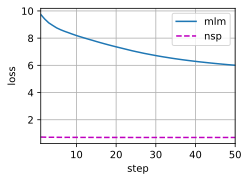

In [25]:
# Pretrain BERT(net) on the WikiText-2(train_iter) dataset
# 在 WikiText-2 数据集（train_iter）上对 BERT 模型（net）进行预训练
def train_bert(train_iter, net, loss, vocab_size, device, num_steps):
    # 将模型放到设备上并使用 DataParallel 进行多 GPU 训练
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    # 定义优化器和学习率
    trainer = torch.optim.Adam(net.parameters(), lr=1e-3)
    # 初始化步数和计时器
    step, timer = 0, d2l.Timer()
    # 创建动画绘图器
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                           xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 初始化指标累加器
    metric = d2l.Accumulator(4)
    # 标志位，判断是否达到指定步数
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            # 将数据移动到设备上
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(device[0])
            valid_lens_x = valid_lens_x.to(device[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            # 梯度清零
            trainer.zero_grad()
            # 计时开始
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                                                   pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            # 计算损失并进行反向传播和参数更新
            l.backward()
            trainer.step()
            # 累加指标和记录时间
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            # 绘制动画图像
            animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))    
            step += 1
            # 如果达到指定步数，设置标志位并跳出循环
            if step == num_steps:
                num_steps_reached = True
                break
                
    # 打印最终结果和性能指标
    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentensece pairs/sec on '
          f'{str(devices)}')

# 调用函数进行 BERT 模型的预训练
train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [26]:
# Representing Text with BERT
# 使用 BERT 表示文本
def get_bert_encoding(net, tokens_a, tokens_b=None):
    # 获取 tokens 和 segments
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    # 将 tokens 转换为 token_ids，并添加批次维度
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)   
    # 将 segments 转换为 tensor，并添加批次维度
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    # 计算有效长度并添加批次维度
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    # 使用 BERT 进行编码
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [27]:
# Consider the sentence "a crane is flying"
# 考虑句子 "a crane is flying"
tokens_a = ['a', 'crane', 'is', 'flying']
# 使用 get_bert_encoding 函数对句子进行编码
encoded_text = get_bert_encoding(net, tokens_a)
# 提取编码后的句子的 CLS 标记
encoded_text_cls = encoded_text[:, 0, :]
# 提取编码后的句子中 "crane" 的表示
encoded_text_crane = encoded_text[:, 2, :]
# 输出编码后的句子的形状、CLS 标记的形状以及 "crane" 的前三个表示值
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.4110,  1.2578, -0.4897], device='cuda:0', grad_fn=<SliceBackward0>))

In [28]:
# Now consider a sentence pair "a crane driver came" and "he just left"
# 现在考虑句子对 "a crane driver came" 和 "he just left"
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']  
# 使用 get_bert_encoding 函数对句子对进行编码
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 提取编码后的句子对的 CLS 标记
encoded_pair_cls = encoded_pair[:, 0, :]
# 提取编码后的句子对中 "crane" 的表示
encoded_pair_crane = encoded_pair[:, 2, :]
# 输出编码后的句子对的形状、CLS 标记的形状以及 "crane" 的前三个表示值
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.4008,  1.2771, -0.6009], device='cuda:0', grad_fn=<SliceBackward0>))